In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import h5py

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

from scipy.signal import welch
from scipy.optimize import curve_fit

In [3]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/gas_collisiions/analyss_notebooks/../analysis_utils.py'>

#### Get pulse sizes from the electric waveform

In [4]:
def get_pulse_area(tt, dd):
    # Time in s, drive signal in V
    noise = np.mean(dd[tt < -0.5e-7])
    area = np.trapz(dd-noise, x=tt)
    
    return area

def process_pulse_waveforms(files):
    tt = None
    dds, aas = [], []
    for file in files:
        data = np.genfromtxt(file, delimiter=',', skip_header=1)
        _tt, _dd = data.T[0], data.T[1]
        _aa = get_pulse_area(_tt, _dd)

        if tt is None:
            tt = _tt

        dds.append(_dd)
        aas.append([_aa])

    return tt, dds, aas

In [8]:
# folder = r'E:\pulse_waveform\20241204_quantum_composers'
folder = r'/Volumes/LaCie/pulse_waveform/20241204_quantum_composers'

tt = None
dds_mean, dds_std, aas_mean, aas_std = [], [], [], []

for dataset in ['2_5v', '5v', '7_5v', '10v', '12_5v', '15v', '17_5v', '20v']:
    files = glob.glob(os.path.join(folder, f'{dataset}/C3_*.CSV'))
    _tt, dds, aas = process_pulse_waveforms(files)
    
    mean = np.mean(dds, axis=0)
    std = np.std(dds, axis=0)

    aa_mean = np.mean(aas)
    aa_std  = np.std(aas)

    if tt is None:
        tt = _tt

    dds_mean.append(mean)
    aas_mean.append(aa_mean)
    dds_std.append(std)
    aas_std.append(aa_std)

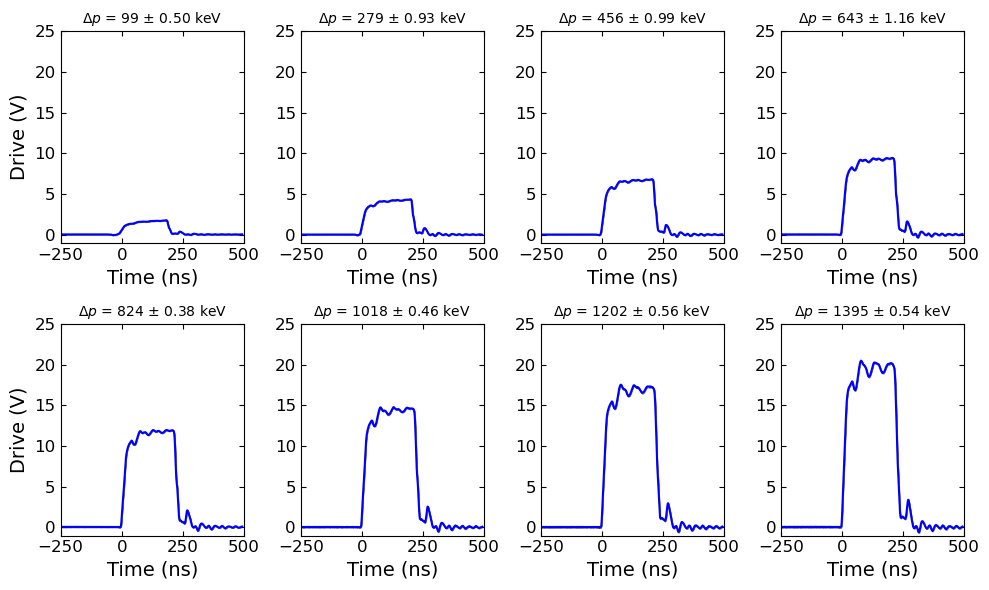

In [10]:
charge = 8
efield = 138 # V/m

fig, axes = plt.subplots(2, 4, figsize=(10, 6))
for i in range(8):
    ax = axes.flatten()[i]

    amp_kev = charge * aas_mean[i] * efield * 1.602e-19 * utils.SI2ev / 1000
    amp_kev_std = charge * aas_std[i] * efield * 1.602e-19 * utils.SI2ev / 1000
    
    ax.fill_between(tt*1e9, dds_mean[i]-dds_std[i], dds_mean[i]+dds_std[i], color='grey', alpha=0.95)
    ax.plot(tt*1e9, dds_mean[i], color='blue')
    
    ax.set_title(fr'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV', fontsize=10)

    ax.set_xlim(-250, 500)
    ax.set_ylim(-1, 25)
    
    if i == 0 or i == 4:
        ax.set_ylabel('Drive (V)')

    ax.set_xlabel('Time (ns)')

fig.tight_layout()

#### Calibrate the displacement noise

In [4]:
sphere = 'sphere_20251129'
folder = '20251201_electric_calibration_7e-8mbar_0'
file_prefix = '20251201_d_p8e_117khz_1vpp_lensholder1'

_files = [rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_0.hdf5',
         rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_1.hdf5',
         rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_2.hdf5',
         rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_3.hdf5',
         rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_4.hdf5']

c_mvs = utils.get_c_mv(_files, vp2p=[1, 1, 1, 1, 1], omegad=117000*2*np.pi, passband=(116700, 117300), searchband=(40000, 50000), charge=8, n_chunk=1, efield=138)
c_mv = np.mean(c_mvs)

print(f'c_mv: {c_mv}')

c_mv: 8.154307475840132e-08


Delta_p: 86.4123015254201 keV/c


(1e-28, 1e-19)

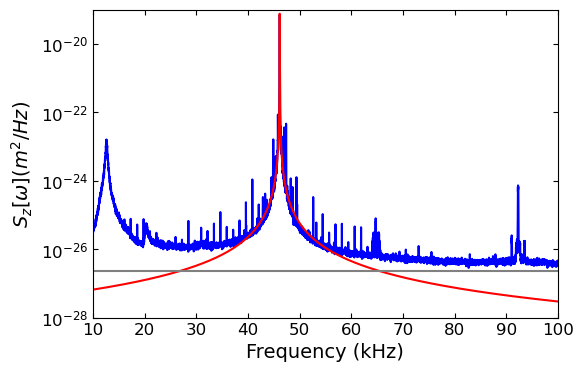

In [5]:
_file = rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/20251201_d_p8e_nodrive_1.hdf5'
ff, sz_measured, sf_measured, chi_2_convolved, dp_kev, fig, ax = utils.get_effective_force_noise(_file, c_mv, int_band=(30000, 90000), 
                                                                                                fit_band=(25000, 60000), nperseg=2**19, plot_fit=True)
print(f'Delta_p: {dp_kev} keV/c')

_idx = np.logical_and(ff>250000, ff<300000)
sz_imp = np.mean(sz_measured[_idx])

ax.plot(np.linspace(10, 100, 50), np.full(50, sz_imp), 'gray')
ax.set_ylim(1e-28, 1e-19)

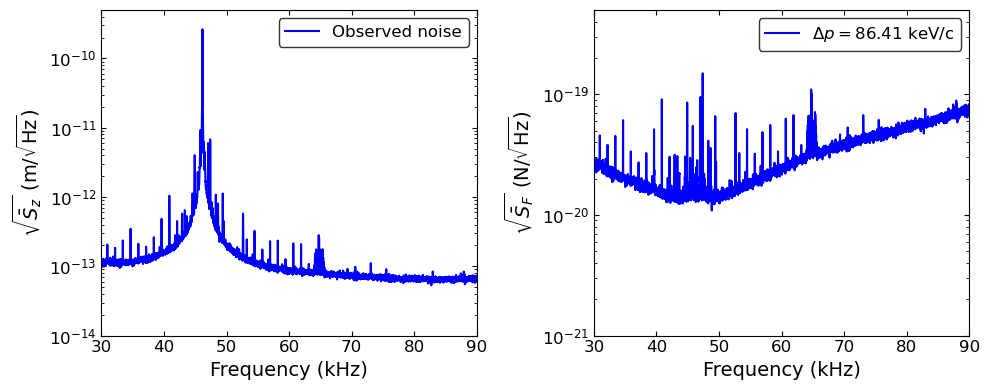

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(ff/1000, np.sqrt(sz_measured), color='b', label='Observed noise')
axes[1].plot(ff/1000, np.sqrt(sf_measured), color='b', label=fr'$\Delta p = {dp_kev:.2f}$ keV/c')

for ax in axes:
    ax.set_yscale('log')
    ax.set_xlim(30, 90)
    ax.set_xlabel('Frequency (kHz)')
axes[0].legend(edgecolor='k')
axes[1].legend(edgecolor='k')
axes[0].set_ylabel(r'$\sqrt{\bar{S}_{z}}$ (m/$\sqrt{\mathrm{Hz}}$)')
axes[1].set_ylabel(r'$\sqrt{\bar{S}_{F}}$ (N/$\sqrt{\mathrm{Hz}}$)')

axes[0].set_ylim(1e-14, 5e-10)
axes[1].set_ylim(1e-21, 5e-19)

fig.align_labels()
fig.tight_layout()

#### Reconstruction using the old code

In [6]:
def save_recon_amps(outfile, outdir, voltages, unnormalized_amps, unnormalized_amps_noise_5v):
    # outfile_name = 'sphere_20250103_calibration_all.h5py'
    # out_dir = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed'
    # voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

    with h5py.File(os.path.join(outdir, outfile), 'w') as fout:
        g = fout.create_group('calibration_data_processed')
        
        for i, v in enumerate(voltages):
            g.create_dataset(f'unnormalized_amps_{str(v)}v', data=unnormalized_amps[i], dtype=np.float64)
        g.create_dataset(f'unnormalized_amps_noise_5v', data=unnormalized_amps_noise_5v, dtype=np.float64)

        fout.close()

In [4]:
data_folder = r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20251129/20251201_p8e_7e-8mbar_d137khz_0'
data_prefix = '20251201_dfg_p8e_200ns_'
voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

amps_all_0 = []
amps_noise_0 = None
for i, v in enumerate(voltages):
    print(v)
    dataset = data_prefix + f'{v}v'
    combined_path = os.path.join(data_folder, f'{dataset}*.hdf5')
    data_files = glob.glob(combined_path)

    amps = utils.get_unnormalized_amps(data_files, 
                            noise=False,
                            no_search=False,
                            positive_pulse=True,
                            notch_freq=137000,
                            passband=(40000, 60000),
                            analysis_window_length=50000,
                            prepulse_window_length=50000,
                            search_window_length=250,
                            search_offset_length=20,
                            lowpass_freq=60000
                            )

    if v == 5:
        amps_noise_0 = utils.get_unnormalized_amps(data_files, 
                        noise=True,
                        no_search=True,
                        positive_pulse=True,
                        notch_freq=137000,
                        passband=(40000, 60000),
                        analysis_window_length=50000,
                        prepulse_window_length=50000,
                        search_window_length=250,
                        search_offset_length=20,
                        lowpass_freq=60000
                        )
            
    amps_all_0.append(np.asarray(amps))

2.5
Skipping pulse too close to the beginning of file
Skipping pulse too close to the beginning of file
5
Skipping pulse too close to the beginning of file
7.5
Skipping pulse too close to the beginning of file
10
Skipping pulse too close to the beginning of file
12.5
15
17.5
20
Skipping pulse too close to the end of file


In [9]:
outfile = '20251201_p8e_7e-8mbar_d137khz_0_recon.h5py'
outdir  = r'/Users/yuhan/work/nanospheres/gas_collisiions/data_processed'

save_recon_amps(outfile=outfile, outdir=outdir, voltages=voltages, unnormalized_amps=amps_all_0, unnormalized_amps_noise_5v=amps_noise_0)

In [10]:
data_folder = r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20251129/20251201_p8e_7e-8mbar_d137khz_1'
data_prefix = '20251201_dfg_p8e_200ns_'
voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

amps_all_1 = []
amps_noise_1 = None
for i, v in enumerate(voltages):
    print(v)
    dataset = data_prefix + f'{v}v'
    combined_path = os.path.join(data_folder, f'{dataset}*.hdf5')
    data_files = glob.glob(combined_path)

    amps = utils.get_unnormalized_amps(data_files, 
                            noise=False,
                            no_search=False,
                            positive_pulse=True,
                            notch_freq=137000,
                            passband=(40000, 60000),
                            analysis_window_length=50000,
                            prepulse_window_length=50000,
                            search_window_length=250,
                            search_offset_length=20,
                            lowpass_freq=60000
                            )

    if v == 5:
        amps_noise_1 = utils.get_unnormalized_amps(data_files, 
                        noise=True,
                        no_search=True,
                        positive_pulse=True,
                        notch_freq=137000,
                        passband=(40000, 60000),
                        analysis_window_length=50000,
                        prepulse_window_length=50000,
                        search_window_length=250,
                        search_offset_length=20,
                        lowpass_freq=60000
                        )
            
    amps_all_1.append(np.asarray(amps))

2.5
5
7.5
10
Skipping pulse too close to the beginning of file
12.5
15
Skipping pulse too close to the end of file
17.5
20


In [11]:
outfile = '20251201_p8e_7e-8mbar_d137khz_1_recon.h5py'
outdir  = r'/Users/yuhan/work/nanospheres/gas_collisiions/data_processed'

save_recon_amps(outfile=outfile, outdir=outdir, voltages=voltages, unnormalized_amps=amps_all_1, unnormalized_amps_noise_5v=amps_noise_1)

In [12]:
# Combine the amplitudes reconstructed for the two datasets
amps_all = []
amps_noise = np.concatenate([amps_noise_0, amps_noise_1])

for i in range(8):
    amps_all.append(np.concatenate([amps_all_0[i], amps_all_1[i]]))

pulse_amp = np.asarray([99, 279, 456, 643, 824, 1018, 1202, 1395])

bins = np.arange(0, 3000, 50) / 18590.907826861265
hhs, bcs, gps = utils.fit_amps_gaus(amps_all, bins=bins, noise=False, return_bins=False)
hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus([amps_noise], bins=bins, noise=True, return_bins=False)

amp2kevs = pulse_amp / np.asarray(gps).T[1]
amp2kev_all = amp2kevs[-1]

print('amp2kev:', amp2kev_all)

amp2kev: 18628.756456109044


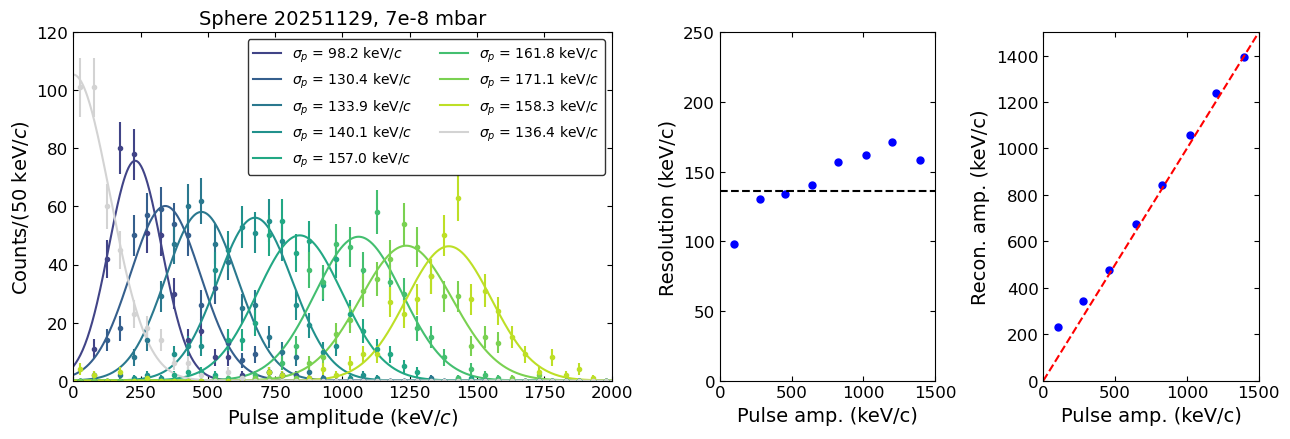

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4.5), width_ratios=[2.5, 1, 1])

xx = np.linspace(0, np.max(bcs[0]), 1000)

cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, 8))
for i in range(pulse_amp.size):
    axes[0].errorbar(bcs[i]*amp2kev_all, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    axes[0].plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), label=fr'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/$c$', color=colors[i])

axes[0].errorbar(bcs_noise[0]*amp2kev_all, hhs_noise[0], yerr=np.sqrt(hhs_noise[0]), fmt='.', color='lightgrey')
axes[0].plot(xx*amp2kev_all, utils.gauss_zero(xx, *gps_noise[0]), label=fr'$\sigma_p$ = {gps_noise[0][1]*amp2kev_all:.1f} keV/$c$', color='lightgrey')

axes[0].set_xlim(0, 2000)
axes[0].set_ylim(0, 120)
axes[0].legend(edgecolor='k', ncol=2, fontsize=10)
axes[0].set_xlabel(r'Pulse amplitude (keV/$c$)')
axes[0].set_ylabel(r'Counts/(50 keV/$c$)')
axes[0].set_title('Sphere 20251129, 7e-8 mbar')

axes[1].plot(pulse_amp, np.asarray(gps).T[2]*amp2kev_all, 'b.', markersize=10)
axes[1].set_xlim(0, 1500)
axes[1].set_ylim(0, 250)
axes[1].set_xlabel('Pulse amp. (keV/c)')
axes[1].set_ylabel('Resolution (keV/c)')
axes[1].plot(np.linspace(0, 1500, 50), np.full(50, gps_noise[0][1]*amp2kev_all), 'k--')

axes[2].plot(pulse_amp, np.asarray(gps).T[1]*amp2kev_all, 'b.', markersize=10)
axes[2].plot(np.linspace(0, 1500, 50), np.linspace(0, 1500, 50), 'r--')
axes[2].set_xlim(0, 1500)
axes[2].set_ylim(0, 1500)
axes[2].set_xlabel('Pulse amp. (keV/c)')
axes[2].set_ylabel('Recon. amp. (keV/c)')

fig.tight_layout()

#### Look for time-dependence in the reconstructed pulses

In [ ]:
data_folders = [r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20251129/20251201_p8e_7e-8mbar_d137khz_0', 
                r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20251129/20251201_p8e_7e-8mbar_d137khz_1']
data_prefix = '20251201_dfg_p8e_200ns_'
voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

pulse_times_all = []
for data_folder in data_folders:

    pulse_times_list = []
    for v in voltages:
        dataset = data_prefix + f'{v}v'
        combined_path = os.path.join(data_folder, f'{dataset}*.hdf5')
        data_files = glob.glob(combined_path)

        _, pulse_times = utils.get_pulse_times(data_files, True, prepulse_window_length=50000, analysis_window_length=50000)
        pulse_times_list.append(pulse_times)

    pulse_times_all.append(pulse_times_list)

pulse_time_all = [ np.concatenate([ pulse_times_all[0][i], pulse_times_all[1][i]]) for i in range(8) ]

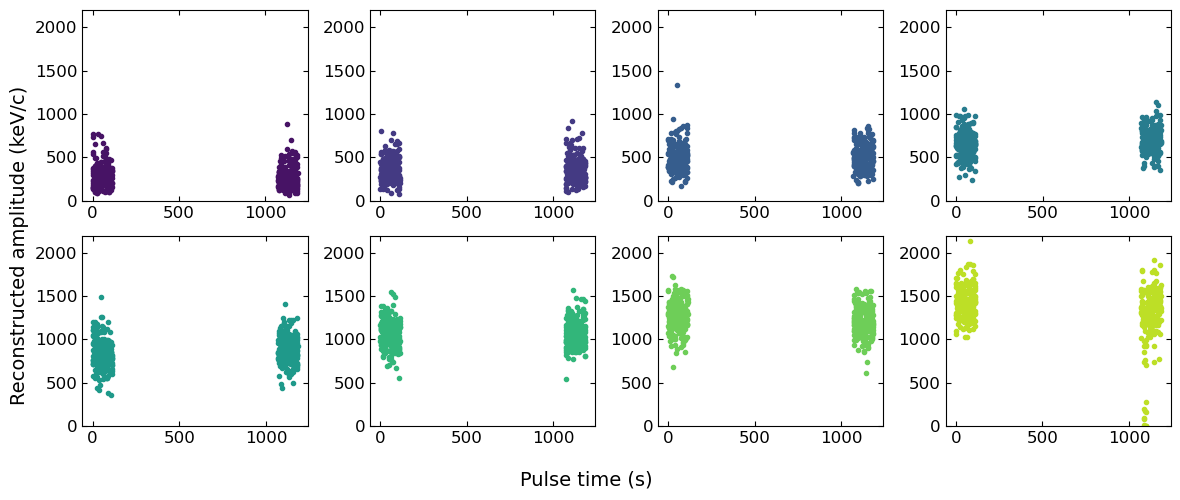

In [376]:
cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.05, 0.9, 8))

fig, axes = plt.subplots(2, 4, figsize=(12, 5))

for i in range(8):
    ax = axes[i//4][i%4]
    ax.plot(pulse_time_all[i]-pulse_time_all[i][0], amps_all[i]*amp2kev_all, '.', color=colors[i])
    ax.set_ylim(0, 2200)

fig.supylabel('Reconstructed amplitude (keV/c)', fontsize=14)
fig.supxlabel('Pulse time (s)', fontsize=14)
fig.tight_layout()

Text(0.5, 0, 'Pulse time (s)')

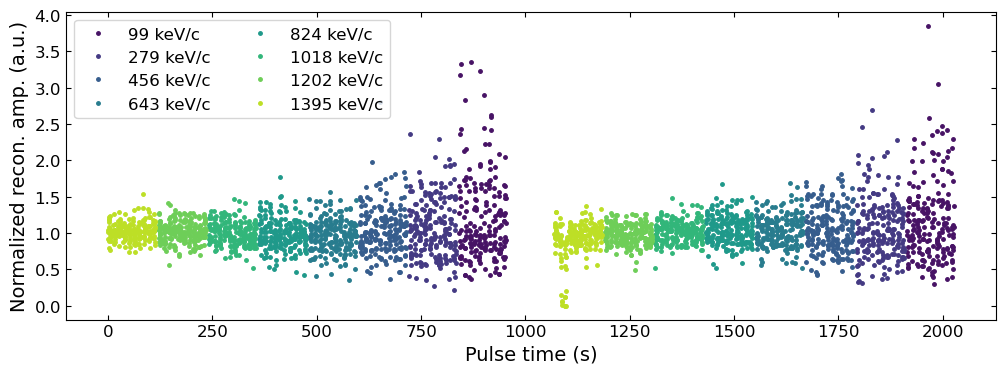

In [344]:
# Use the measured applied vs. reconstructed amps
# to normalize the reconstructed amplitudes
norm_factor = np.asarray(gps).T[1]

cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.05, 0.9, 8))

fig = plt.figure(figsize=(12, 4))
for i in range(8):
    plt.plot(pulse_time_all[i]-pulse_time_all[7][0], amps_all[i]/norm_factor[i], '.', label=f'{pulse_amp[i]} keV/c', color=colors[i], markersize=5)

plt.legend(frameon=True, ncol=2)
plt.ylabel('Normalized recon. amp. (a.u.)')
plt.xlabel('Pulse time (s)')

#### Look at the calibration tone

In [14]:
from scipy.signal import butter, sosfilt

def demodulate(_sig, _lo, f_samp, f_lp):
    mixed_sig = _sig * _lo

    sos = butter(N=2, Wn=f_lp, btype='lowpass', output='sos', fs=f_samp)
    filtered = sosfilt(sos, mixed_sig)
    
    return filtered

In [17]:
data_folders = [r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20251129/20251201_p8e_7e-8mbar_d137khz_0', 
                r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20251129/20251201_p8e_7e-8mbar_d137khz_1']
data_prefix = '20251201_dfg_p8e_200ns_'

prepulse_window_length, analysis_window_length = 50000, 50000
tone_level = []
tone_level_pulses = []

for i in range(10):
    _file = rf'{data_folders[0]}/{data_prefix}20v_{i}.hdf5'

    dtt, nn = utils.load_timestreams(_file, ['D', 'F', 'G'])
    fs = int(np.ceil(1 / dtt))
    zz, ff, dd = nn[0], nn[1], nn[2]

    positive_pulse = True
    trigger_level = positive_pulse * 0.5
    pulse_idx = utils.get_pulse_idx(dd, trigger_level, positive_pulse)
    good_idx = np.logical_and(pulse_idx > prepulse_window_length, pulse_idx<(dd.size-analysis_window_length))
    good_pulse_idx = pulse_idx[good_idx]

    ee = demodulate(zz, ff, fs, 10)
    # Reject the first 200,000 samples because there are
    # funny FFT windowing effects
    ee[0:int(2e5)] = np.nan

    tone_level.append(ee)

    ee_pulse = np.zeros(good_pulse_idx.size)
    for i, idx in enumerate(good_pulse_idx):
        ee_pulse[i] = np.mean(ee[idx-analysis_window_length:idx+analysis_window_length])
    tone_level_pulses.append(ee_pulse)

tone_level = np.asarray(tone_level)

Text(0, 0.5, 'Recon. amp. (keV/c)')

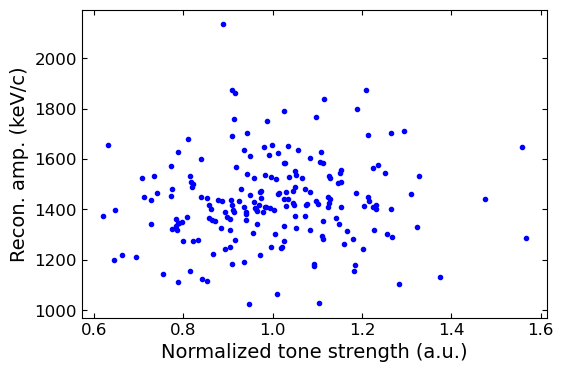

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

tone_strength = np.abs(np.concatenate(tone_level_pulses))
ax.plot(tone_strength/np.mean(tone_strength), amps_all_0[7]*amp2kev_all, 'b.')

ax.set_xlabel('Normalized tone strength (a.u.)')
ax.set_ylabel('Recon. amp. (keV/c)')

Text(0, 0.5, 'Counts')

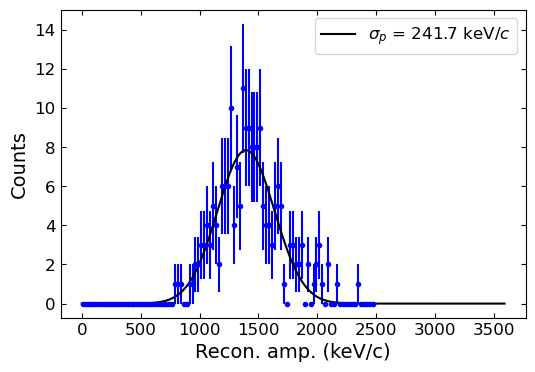

In [55]:
amps_mod = amps_all_0[7] / tone_strength

bins = np.arange(0, 5000, 50) / 1.431984296322458
hhs, bcs, gps = utils.fit_amps_gaus([amps_mod], bins=bins, noise=False, return_bins=False)
amp2kev_mod = 1395 / gps[0][1]

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

xx = np.linspace(0, 5000, 200)
ax.errorbar(bcs[0]*amp2kev_mod, hhs[0], yerr=np.sqrt(hhs[0]), fmt='b.')
ax.plot(xx*amp2kev_mod, utils.gauss(xx, *gps[0]), 'k', label=fr'$\sigma_p$ = {gps[0][2]*amp2kev_mod:.1f} keV/$c$')

ax.legend()
ax.set_xlabel('Recon. amp. (keV/c)')
ax.set_ylabel('Counts')